In [17]:
import pandas as pd
import os
import json
import requests
import json
import matplotlib.pyplot as plt

DATADIR = "../../dataset"


In [3]:
# load wikidata and pbdb data
wiki, pbdb = pd.read_csv(os.path.join(DATADIR, "wikidata","processed","data.csv"), index_col = "id"), \
pd.read_csv(os.path.join(DATADIR, "pbdb","data.csv"))

In [4]:
wiki["taxon_name"].fillna(wiki["species_name_value"],inplace=True)

In [4]:
# get all taxon ranks in wikidata
all_ranks = wiki[wiki["taxon_rank"].notna()]["taxon_rank"].unique().tolist()

In [5]:
# get all taxon names in wikidata
all_taxon_names = set(wiki[wiki["taxon_name"].notna()]["taxon_name"].unique())

In [6]:
# get all accepted names, phylum names, class names, order names, family names and genus names in pbdb
accepted_names, phylums, classes, orders, families, genuses = \
[i for i in pbdb["accepted_name"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb["phylum"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb["class"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb["order"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb["family"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb["genus"].unique().tolist() if str(i) != "nan"]


In [7]:
pbdb["accepted_rank"].unique()

array(['genus', 'species', 'phylum', 'family', 'subclass', 'kingdom',
       'class', 'order', 'subgenus', 'superphylum', 'unranked clade',
       'subphylum', 'subfamily', 'tribe', 'subkingdom', 'superfamily',
       'superorder', 'subspecies', 'suborder', 'superclass', 'infraclass',
       'infraorder', 'subtribe', 'informal'], dtype=object)

In [8]:
# get the missing names (those cannot be found in taxon_names)
missing_accepted_names, missing_phylums, missing_classes, missing_orders, missing_families, missing_genuses = \
[name for name in accepted_names if name not in all_taxon_names], \
[name for name in phylums if name not in all_taxon_names], \
[name for name in classes if name not in all_taxon_names], \
[name for name in orders if name not in all_taxon_names], \
[name for name in families if name not in all_taxon_names], \
[name for name in genuses if name not in all_taxon_names]

print("accepted names: missing: ", len(missing_accepted_names), ", all: ",len(accepted_names))
print("phylums: missing: ", len(missing_phylums), ", all: ",len(phylums))
print("classes: missing: ", len(missing_classes), ", all: ",len(classes))
print("orders: missing: ", len(missing_orders), ", all: ",len(orders))
print("families: missing: ", len(missing_families), ", all: ",len(families))
print("genuses: missing: ", len(missing_genuses), ", all: ",len(genuses))

accepted names: missing:  132707 , all:  180470
phylums: missing:  15 , all:  60
classes: missing:  30 , all:  165
orders: missing:  182 , all:  1147
families: missing:  1270 , all:  8574
genuses: missing:  34575 , all:  63779


In [9]:
# get pbdb records where there is no match for neither accepted name nor any of the taxon names in all taxon ranks
pbdb_no_match = pbdb[(~pbdb["accepted_name"].isin(all_taxon_names)) & (~pbdb["phylum"].isin(all_taxon_names)) & (~pbdb["class"].isin(all_taxon_names)) & (~pbdb["order"].isin(all_taxon_names)) & (~pbdb["family"].isin(all_taxon_names)) & (~pbdb["genus"].isin(all_taxon_names))]

In [10]:
pbdb_no_match.shape

(7127, 18)

In [11]:
no_match_accepted_names, no_match_phylums, no_match_classes, no_match_orders, no_match_families, no_match_genuses = \
[i for i in pbdb_no_match["accepted_name"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb_no_match["phylum"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb_no_match["class"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb_no_match["order"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb_no_match["family"].unique().tolist() if str(i) != "nan"], \
[i for i in pbdb_no_match["genus"].unique().tolist() if str(i) != "nan"]

In [507]:
no_match_accpeted_names_split = set()
for name_list in [name.split() for name in no_match_accepted_names]:
    for a_name in name_list:
        no_match_accpeted_names_split.add(a_name)
no_match_accpeted_names_split = list(no_match_accpeted_names_split)        

In [508]:
all_no_match_names = set(no_match_accpeted_names_split + no_match_phylums + no_match_classes + no_match_orders + no_match_families + no_match_genuses)

In [463]:
def query_data(my_query): 
    return requests.get(f"https://www.wikidata.org/w/api.php?action=wbsearchentities&search={my_query}&language=en&format=json").json()["search"]


cache = dict()
if os.path.isfile("../../dataset/wikidata/processed/cache_for_pbdb_names.json"):
        with open("../../dataset/wikidata/processed/cache_for_pbdb_names.json", "r") as f:
            cache = json.load(f)

search_result = dict()
for query in all_no_match_names:
    if query not in cache:
        query_result = query_data(query)
        cache[query] = query_result
        with open("../../dataset/wikidata/processed/cache_for_pbdb_names.json", "w") as f:
            json.dump(cache, f)
        
    else:
        query_result = cache[query]
    
    search_result[query] = query_result

effective_names = [name for name in search_result if search_result[name] != []]
all_pbdb_ranks = pbdb["accepted_rank"].unique().tolist()
for name in effective_names:
    results = search_result[name]
    meaningful_results = []
    for result in results:
        try:
            if any(rank in result["description"] for rank in all_pbdb_ranks):
                meaningful_results.append(result)
        except KeyError:
            continue
    search_result[name] = meaningful_results

name_id_dict = {name:search_result[name][0]["id"] for name in search_result if len(search_result[name]) == 1} 

In [13]:
def get_name_id_dict (wiki):
    '''
    takes the wiki dataset and build a taxon_name to id code lookup dict 
    return a dict, where keys are taxon names, values are lists of corresponding id (Q code) 
    '''
    name_id_dict = {}
    for idx in wiki.index:
        name = wiki.loc[idx,"taxon_name"]
        if name not in name_id_dict:
            name_id_dict[name] = [idx]
        else:
            name_id_dict[name].append(idx)
    return name_id_dict

def link_data(pbdb,name_id_lookup):
    '''
    link the pbdb data with wiki data by appending to pbdb 1, a column "wiki_ref"
    to the pbdb
    where for each entry it contains a list of wiki Q code(s) that 
    corresponds to the fossil record, if there is no match then the list
    is empty, 2, the 
    the matching priority is:
    accepted_name -> genus -> family -> order -> class -> phylum
    '''
    matching_priorities = ["accepted_name", "genus","family","order","class","phylum"]
    wiki_ref_list, wiki_ref_rank_list, lowest_matched_rank = [], [], []
    #pbdb["wiki_ref"], pbdb["wiki_ref_rank"], pbdb["lowest_matched_rank"]=[np.nan]*pbdb.shape[0],[np.nan]*pbdb.shape[0],[np.nan]*pbdb.shape[0]
    for i, row in pbdb.iterrows():
        if i % 10000 == 0:
            print(i)
        for testing_rank in matching_priorities:
            name = row[testing_rank]
            if name in name_id_lookup:
                codes = name_id_lookup[name]
                ranks = [rank_info[wiki.loc[code]["taxon_rank"]] if str(wiki.loc[code]["taxon_rank"]) != "nan" else "nan" for code in codes]
                wiki_ref_list.append("_".join(codes)) 
                wiki_ref_rank_list.append("_".join(ranks)) 
                if testing_rank == "accepted_name":
                    lowest_matched_rank.append(row["accepted_rank"]) 
                else:
                    lowest_matched_rank.append(testing_rank) 
                break
        if len(wiki_ref_list) == i:
            wiki_ref_list.append(np.nan) 
            wiki_ref_rank_list.append(np.nan)
            lowest_matched_rank.append(np.nan) 
    pbdb["wiki_ref"], pbdb["wiki_ref_rank"], pbdb["lowest_matched_rank"] = wiki_ref_list, wiki_ref_rank_list, lowest_matched_rank
    return pbdb

In [571]:
rank_code_name_lookup = dict()
for rank in all_ranks:
    result = query_data(rank)
    rank_info[rank] = result[0]["label"]
    if len(result) != 1:
        print(rank)

In [ ]:
# match pbdb name to wiki Q_code: first match accepted_name, then genus, family, order, class, phylum and kingdom 
pbdb=link_data(pbdb,name_id_lookup)

In [685]:
pbdb.to_csv("../../dataset/pbdb/pbdb_linked.csv",index=False)

In [2]:
pbdb = pd.read_csv("../../dataset/pbdb/pbdb_linked.csv")

In [108]:
# parse the pbdb that are linked to one and only one wiki data entry 
included_pbdb = pbdb[(pbdb["wiki_ref"].notna()) & (~pbdb["wiki_ref"].str.contains("_", na= False))].rename(columns={'occurrence_no': 'id', "accepted_name":"name","accepted_rank":"rank","min_ma":"minma","max_ma":"maxma","wiki_ref":"wikiRef"})[["id","wikiRef","name","rank","minma","maxma","lng","lat"]].to_json(orient="records")
parsed_included_pbdb = json.loads(included_pbdb)

with open("../../dataset/pbdb/pbdb.json","w") as f:
    json.dump(parsed_included_pbdb,f)

In [13]:
pbdb[pbdb["max_ma"]==635]

,min_ma,max_ma
139,541.0,635.0
142,541.0,635.0
172,541.0,635.0
173,541.0,635.0
454,541.0,635.0
...,...,...
1326099,541.0,635.0
1329710,541.0,635.0
1329711,541.0,635.0
1340374,541.0,635.0


In [25]:
fossil_distribution_over_mya = [pbdb[["min_ma","max_ma"]][(pbdb["min_ma"] <= yr) & (pbdb["max_ma"] > yr)].shape[0] for yr in range(1000)] 
    

Text(0.5, 1.0, 'distribution of fossils over mya')

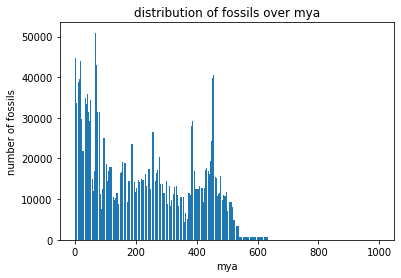

In [32]:
plt.bar(range(1000),fossil_distribution_over_mya)
plt.xlabel("mya")
plt.ylabel("number of fossils")
plt.title("distribution of fossils over mya")

In [16]:
name_id_lookup = get_name_id_dict(wiki)